## 0. Setup

This notebook implements a full **Kaggle pipeline** for the PBC multi-class classification task:

1. Heavy preprocessing & feature engineering  
2. Model comparison across several classifiers using multi-class log loss  
3. Automatic selection of the top-3 models  
4. Hyperparameter tuning of each top-3 model with **Optuna**  
5. Stacking ensemble using the tuned models  
6. Final training on the full dataset and generation of a **Kaggle submission**.

> Note: We use `LabelEncoder` so that all models (including XGBoost, LightGBM, CatBoost) see numeric class labels (0, 1, 2) while we still report / submit with original labels `C`, `CL`, `D`.


In [ ]:
# If running in a fresh environment, uncomment and run this once
# !pip install xgboost optuna lightgbm catboost

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

import optuna

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    StackingClassifier
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

pd.set_option("display.max_columns", 120)
RANDOM_STATE = 42
N_FOLDS = 5

TRAIN_PATH = "https://raw.githubusercontent.com/adnansaki1097/BUBT_AIC/refs/heads/main/train.csv"
TEST_PATH = "https://raw.githubusercontent.com/adnansaki1097/BUBT_AIC/refs/heads/main/test.csv"
SAMPLE_SUB_PATH = "https://raw.githubusercontent.com/adnansaki1097/BUBT_AIC/refs/heads/main/sample_submission.csv"

ModuleNotFoundError: No module named 'optuna'

## 1. Load Data & Basic Preview


In [ ]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
display(train.head())
display(train["Status"].value_counts())
display(train["Status"].value_counts(normalize=True))


Train shape: (15000, 20)
Test shape: (10000, 19)


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,859.0,Placebo,17841.0,F,N,Y,N,N,2.1,396.0,3.70,74.0,2148.0,136.74,144.0,298.0,11.0,4.0,D
1,1,1141.0,Placebo,18102.0,F,N,Y,Y,S,2.1,187.0,3.48,4.0,918.0,120.90,90.0,213.0,12.4,2.0,D
2,2,853.0,D-penicillamine,16728.0,F,N,Y,Y,N,5.7,482.0,3.67,161.0,11552.0,136.74,165.0,102.0,11.5,4.0,D
3,3,1785.0,D-penicillamine,19358.0,F,N,Y,N,N,2.1,350.0,3.36,74.0,661.0,272.80,231.0,166.0,11.4,4.0,D
4,4,1418.0,Placebo,22306.0,F,N,Y,Y,S,2.0,426.0,3.74,86.0,13862.4,136.00,114.0,339.0,11.0,4.0,D


Status
C     10234
D      4423
CL      343
Name: count, dtype: int64

Status
C     0.682267
D     0.294867
CL    0.022867
Name: proportion, dtype: float64

## 2. Quick EDA
check:
- Target distribution  
- Missing values per column  
- Basic numeric statistics


In [ ]:
# Target distribution
print("Target counts:")
print(train["Status"].value_counts())
print("\nTarget proportions:")
print(train["Status"].value_counts(normalize=True))

# Missing values
missing = train.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:")
display(missing[missing > 0])

# Numeric summary
numeric_cols_raw = train.select_dtypes(include=["int64", "float64"]).columns.tolist()
display(train[numeric_cols_raw].describe())


Target counts:
Status
C     10234
D      4423
CL      343
Name: count, dtype: int64

Target proportions:
Status
C     0.682267
D     0.294867
CL    0.022867
Name: proportion, dtype: float64

Missing values per column:


Tryglicerides    8426
Cholesterol      8377
Copper           6662
SGOT             6554
Spiders          6551
Alk_Phos         6550
Hepatomegaly     6547
Drug             6543
Ascites          6536
Platelets         538
Prothrombin        19
dtype: int64

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,15000.000000,15000.00000,15000.00000,15000.000000,6623.000000,15000.000000,8338.000000,8450.000000,8446.000000,6574.000000,14462.000000,14981.000000,15000.000000
mean,7499.500000,1961.48832,19297.11602,1.873353,326.345342,3.521489,75.533329,1635.588473,105.608583,109.534074,254.158927,10.618884,3.011133
std,4330.271354,1269.33249,3676.91184,2.821977,188.022395,0.376376,76.301928,1823.745780,49.984298,48.928323,93.486412,0.719514,0.878935
min,0.000000,3.00000,133.30000,0.300000,66.000000,1.960000,1.000000,289.000000,0.600000,5.000000,0.300000,9.000000,1.000000
25%,3749.750000,1095.00000,16714.00000,0.600000,242.000000,3.290000,31.000000,718.000000,70.000000,79.250000,183.000000,10.100000,2.000000
50%,7499.500000,1783.00000,19358.00000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,251.000000,10.600000,3.000000
75%,11249.250000,2624.00000,22369.00000,1.800000,353.000000,3.770000,86.000000,1644.000000,130.200000,131.000000,312.000000,11.000000,4.000000
max,14999.000000,25340.00000,92111.00000,53.000000,3456.200000,4.800000,588.000000,17046.000000,601.380000,598.000000,1128.000000,18.000000,4.000000


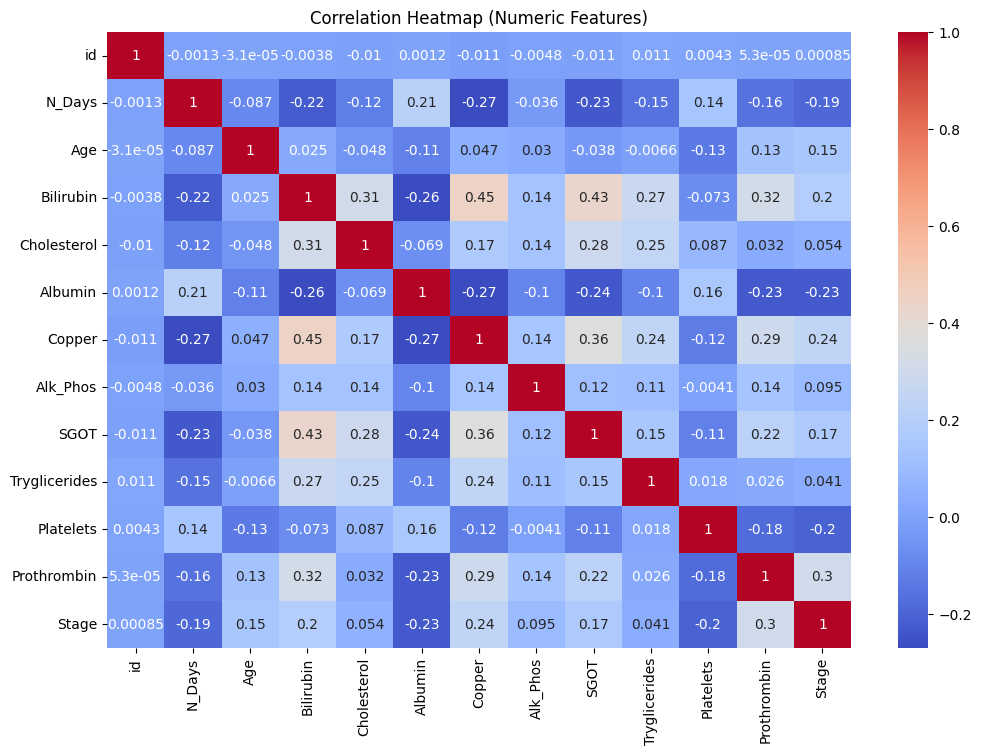

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12,8))
numeric_only = train.select_dtypes(include=["int64", "float64"])  # avoid strings in corr
sns.heatmap(numeric_only.corr(), cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

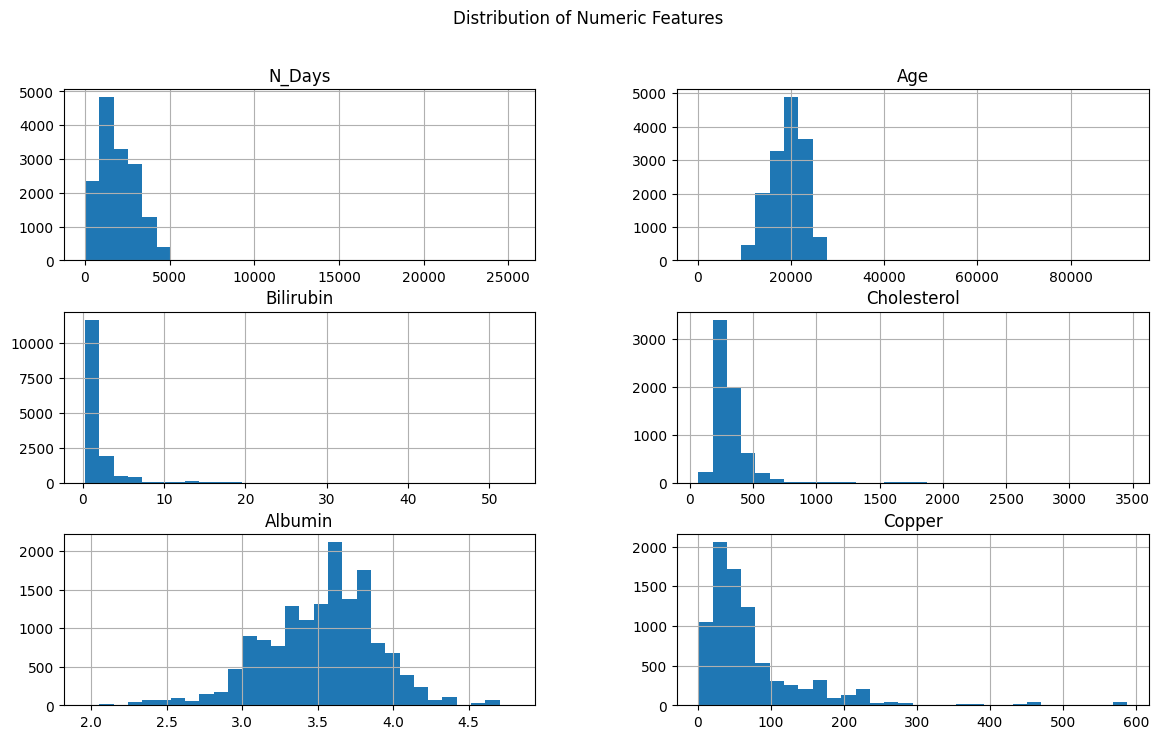

In [ ]:
# Distribution plots for numeric features
numeric_cols_plot = numeric_cols_raw[1:7]  # first 6 numeric features

train[numeric_cols_plot].hist(figsize=(14,8), bins=30)
plt.suptitle("Distribution of Numeric Features")
plt.show()


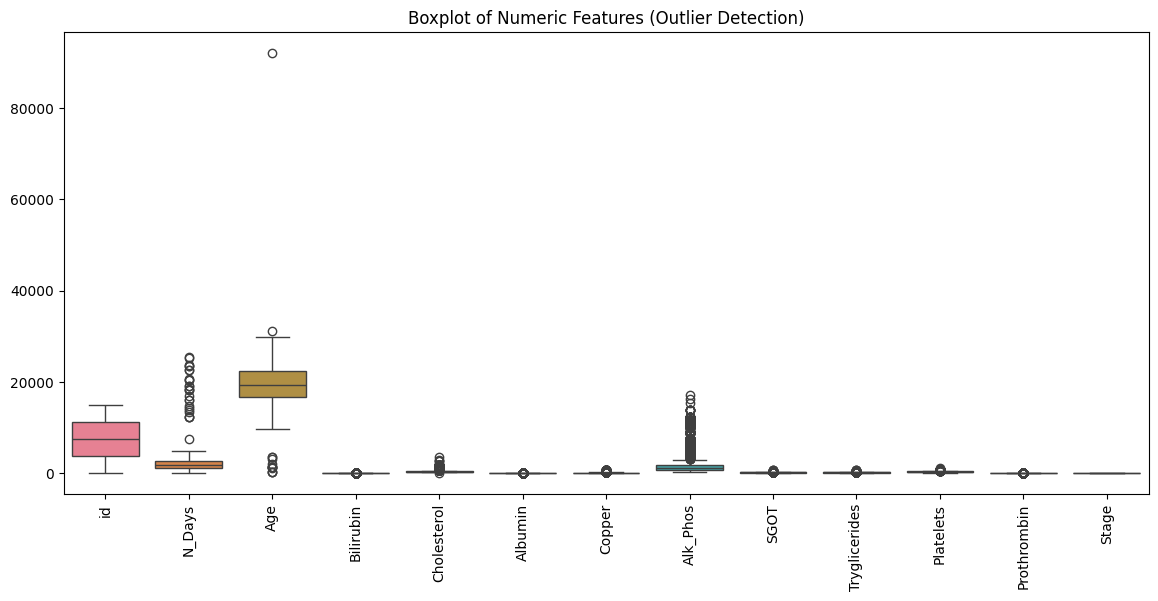

In [ ]:
# Boxplot for spotting outliers
plt.figure(figsize=(14,6))
sns.boxplot(data=train_fe[numeric_cols_raw])
plt.xticks(rotation=90)
plt.title("Boxplot of Numeric Features (Outlier Detection)")
plt.show()

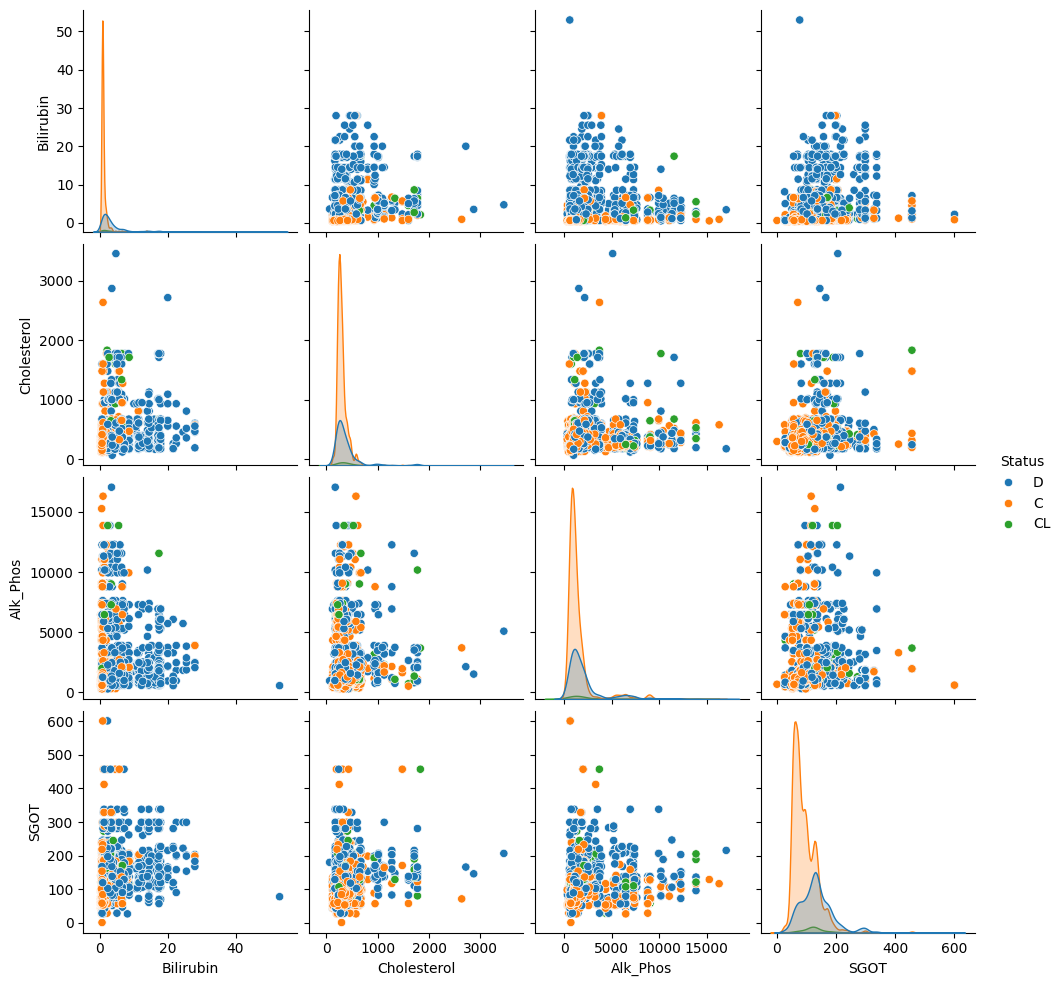

In [ ]:
# PairPlot of important features
important_cols = ['Bilirubin','Cholesterol','Alk_Phos','SGOT','Status']
sns.pairplot(train[important_cols], hue="Status")
plt.show()

## 3. Feature Engineering

- `Age_Years` (Age in years instead of days)  
- Log-transforms for several skewed lab measurements.


In [ ]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Age in years
    if "Age" in df.columns:
        df["Age_Years"] = df["Age"] / 365.25

    # Log-transforms for skewed lab features (safe with NaNs)
    skew_cols = ["Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Tryglicerides"]
    for col in skew_cols:
        if col in df.columns:
            df[f"log1p_{col}"] = np.log1p(df[col])

    return df

train_fe = add_features(train)
test_fe = add_features(test)

target_col = "Status"
feature_cols = [c for c in train_fe.columns if c not in [target_col, "id"]]  # drop target & id

numeric_cols = train_fe[feature_cols].select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = train_fe[feature_cols].select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)


Numeric features: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age_Years', 'log1p_Bilirubin', 'log1p_Cholesterol', 'log1p_Copper', 'log1p_Alk_Phos', 'log1p_SGOT', 'log1p_Tryglicerides']
Categorical features: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


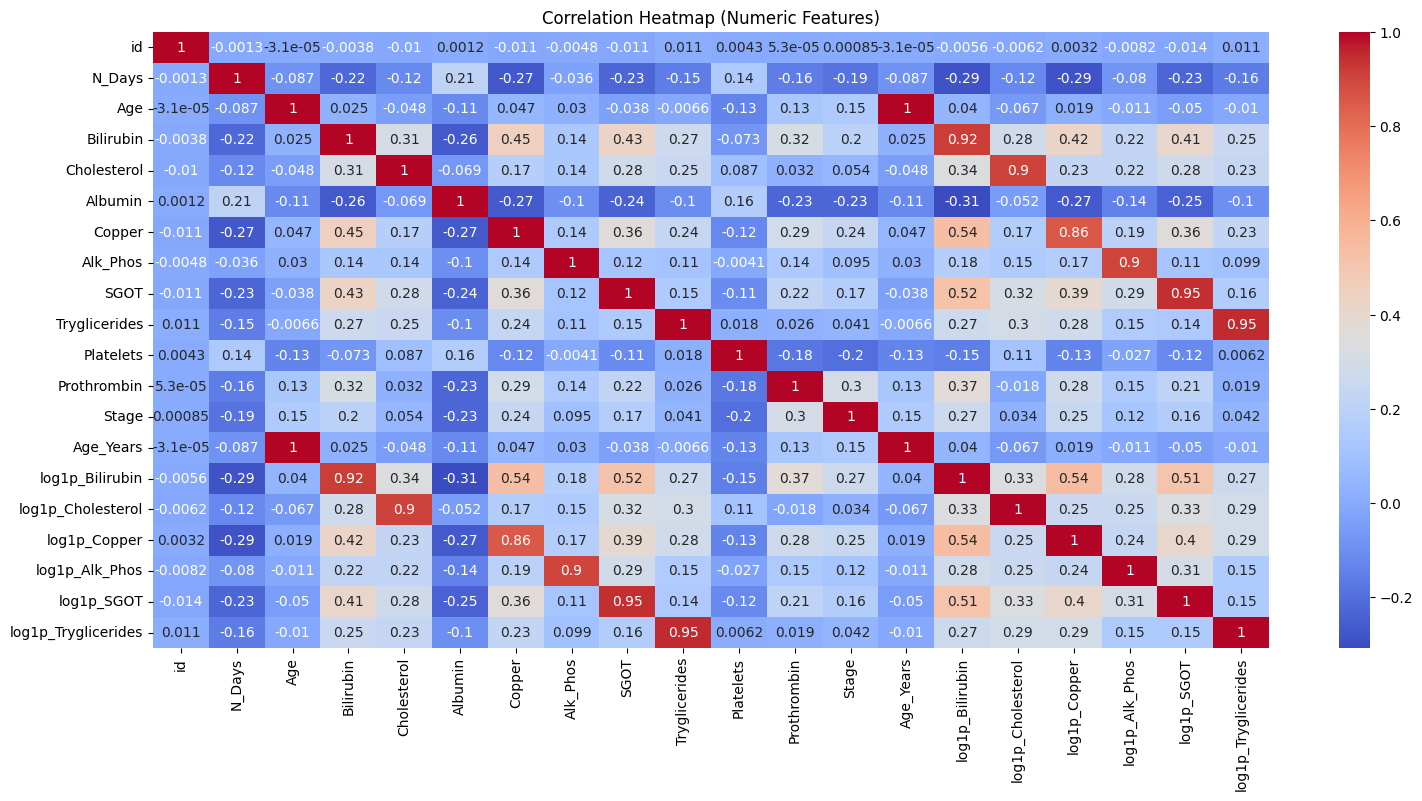

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(18,8))
numeric_only = train_fe.select_dtypes(include=["int64", "float64"])  # avoid strings in corr
sns.heatmap(numeric_only.corr(), cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

## 4. Preprocessing Pipeline + Label Encoding

- Numeric: median imputation + standard scaling  
- Categorical: most-frequent imputation + one-hot encoding  
- Target: `LabelEncoder` to map `{'C','CL','D'}` → `{0,1,2}` for all models.


In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

X = train_fe[feature_cols]
y = train_fe[target_col]

# Label encode target for XGBoost / LightGBM / CatBoost etc.
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Label encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)


Label encoding mapping: {'C': np.int64(0), 'CL': np.int64(1), 'D': np.int64(2)}


### Before/After Encoding Comparison

In [ ]:
# Before/After Preprocessing Preview
from sklearn import set_config
set_config(transform_output="pandas")  # get DataFrame output when possible

print("Original features (head):")
display(train_fe[feature_cols].head())

X_pre = preprocessor.fit_transform(train_fe[feature_cols])

# Try to get feature names; fallback to range indices
try:
    feature_names = X_pre.columns.tolist()
except Exception:
    try:
        # Build names from transformers
        num_names = numeric_cols
        cat_names = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_cols).tolist()
        feature_names = list(num_names) + list(cat_names)
    except Exception:
        feature_names = [f"f{i}" for i in range(X_pre.shape[1])]

df_encoded_preview = pd.DataFrame(X_pre if hasattr(X_pre, 'to_numpy') else X_pre, columns=feature_names)

print("Transformed features (shape):", df_encoded_preview.shape)
display(df_encoded_preview.head())

Original features (head):


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age_Years,log1p_Bilirubin,log1p_Cholesterol,log1p_Copper,log1p_Alk_Phos,log1p_SGOT,log1p_Tryglicerides
0,859.0,Placebo,17841.0,F,N,Y,N,N,2.1,396.0,3.70,74.0,2148.0,136.74,144.0,298.0,11.0,4.0,48.845996,1.131402,5.983936,4.317488,7.672758,4.925368,4.976734
1,1141.0,Placebo,18102.0,F,N,Y,Y,S,2.1,187.0,3.48,4.0,918.0,120.90,90.0,213.0,12.4,2.0,49.560575,1.131402,5.236442,1.609438,6.823286,4.803201,4.510860
2,853.0,D-penicillamine,16728.0,F,N,Y,Y,N,5.7,482.0,3.67,161.0,11552.0,136.74,165.0,102.0,11.5,4.0,45.798768,1.902108,6.180017,5.087596,9.354700,4.925368,5.111988
3,1785.0,D-penicillamine,19358.0,F,N,Y,N,N,2.1,350.0,3.36,74.0,661.0,272.80,231.0,166.0,11.4,4.0,52.999316,1.131402,5.860786,4.317488,6.495266,5.612398,5.446737
4,1418.0,Placebo,22306.0,F,N,Y,Y,S,2.0,426.0,3.74,86.0,13862.4,136.00,114.0,339.0,11.0,4.0,61.070500,1.098612,6.056784,4.465908,9.537008,4.919981,4.744932


Transformed features (shape): (15000, 33)


,num__N_Days,num__Age,num__Bilirubin,num__Cholesterol,num__Albumin,num__Copper,num__Alk_Phos,num__SGOT,num__Tryglicerides,num__Platelets,num__Prothrombin,num__Stage,num__Age_Years,num__log1p_Bilirubin,num__log1p_Cholesterol,num__log1p_Copper,num__log1p_Alk_Phos,num__log1p_SGOT,num__log1p_Tryglicerides,cat__Drug_D-penicillamine,cat__Drug_Placebo,cat__Sex_F,cat__Sex_M,cat__Ascites_N,cat__Ascites_Y,cat__Hepatomegaly_N,cat__Hepatomegaly_Y,cat__Spiders_119.35,cat__Spiders_N,cat__Spiders_Y,cat__Edema_N,cat__Edema_S,cat__Edema_Y
0,-0.868587,-0.396029,0.080318,0.752084,0.474306,0.153573,0.542961,0.917712,1.230899,0.478841,0.530072,1.125111,-0.396029,0.524558,1.295668,0.554352,1.225758,1.062207,1.403267,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-0.646415,-0.325043,0.080318,-0.893201,-0.110236,-1.051786,-0.337502,0.497687,-0.415044,-0.447153,2.477127,-1.150445,-0.325043,0.524558,-1.782654,-4.060422,-0.432458,0.684099,-0.399359,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.873314,-0.698739,1.356061,1.429091,0.394596,1.651663,7.274568,0.917712,1.870988,-1.656392,1.225449,1.125111,-0.698739,1.976752,2.103164,1.866689,4.509004,1.062207,1.926611,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.139045,0.016559,0.080318,0.389964,-0.429076,0.153573,-0.521469,4.525577,3.882696,-0.959173,1.086373,1.125111,0.016559,0.524558,0.788513,0.554352,-1.072772,3.188577,3.221871,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.428183,0.818346,0.044880,0.988249,0.580586,0.360206,8.928407,0.898089,0.316486,0.925497,0.530072,1.125111,0.818346,0.462774,1.595669,0.807273,4.864877,1.045534,0.506347,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
print("Categorical columns before encoding:", categorical_cols)

encoded = preprocessor.fit_transform(train_fe[feature_cols])
print("Shape before encoding:", train_fe[feature_cols].shape)
print("Shape after encoding:", encoded.shape)


Categorical columns before encoding: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
Shape before encoding: (15000, 25)
Shape after encoding: (15000, 33)


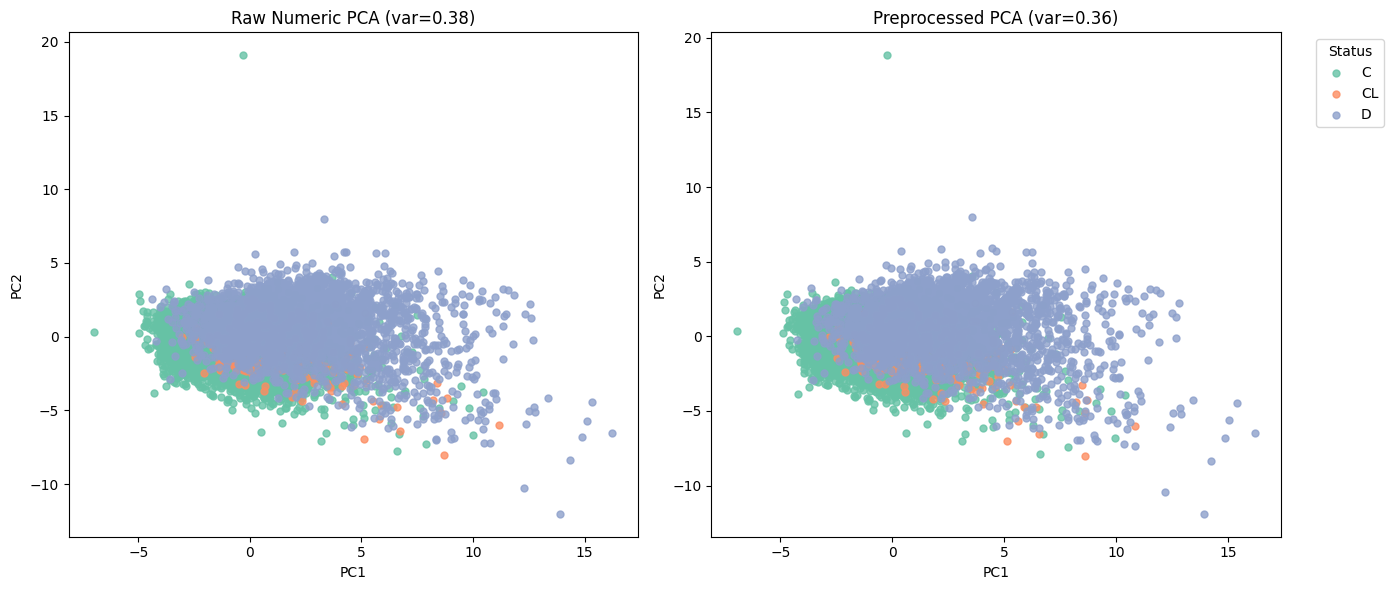

In [ ]:
# PCA Visualization Raw vs Preprocessed (robust indexing)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Raw numeric features: impute (median) + scale
raw_numeric = train_fe[numeric_cols].copy()
raw_numeric_imputed = raw_numeric.fillna(raw_numeric.median())
raw_scaled = StandardScaler().fit_transform(raw_numeric_imputed)

# Full preprocessed feature matrix (fit transformers)
X_trans = preprocessor.fit_transform(train_fe[feature_cols])
X_trans_arr = X_trans.to_numpy() if hasattr(X_trans, 'to_numpy') else X_trans

# PCA to 2D (coerce to ndarray to avoid pandas indexing issues under set_config)
pca_raw = PCA(n_components=2, random_state=RANDOM_STATE)
raw_2d = pca_raw.fit_transform(raw_scaled)
raw_2d_arr = raw_2d.to_numpy() if hasattr(raw_2d, 'to_numpy') else raw_2d

pca_proc = PCA(n_components=2, random_state=RANDOM_STATE)
proc_2d = pca_proc.fit_transform(X_trans_arr)
proc_2d_arr = proc_2d.to_numpy() if hasattr(proc_2d, 'to_numpy') else proc_2d

y_labels = train_fe[target_col].values
classes = np.unique(y_labels)
color_map = dict(zip(classes, sns.color_palette('Set2', n_colors=len(classes))))

fig, axes = plt.subplots(1, 2, figsize=(14,6))

for cls in classes:
    mask = (y_labels == cls)
    axes[0].scatter(raw_2d_arr[mask, 0], raw_2d_arr[mask, 1], label=cls, s=25, alpha=0.8, c=[color_map[cls]])
axes[0].set_title(f"Raw Numeric PCA (var={pca_raw.explained_variance_ratio_.sum():.2f})")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

for cls in classes:
    mask = (y_labels == cls)
    axes[1].scatter(proc_2d_arr[mask, 0], proc_2d_arr[mask, 1], label=cls, s=25, alpha=0.8, c=[color_map[cls]])
axes[1].set_title(f"Preprocessed PCA (var={pca_proc.explained_variance_ratio_.sum():.2f})")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

axes[1].legend(title="Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional heatmap of first 40 rows (commented out to keep runtime lower)
# sample_rows = 40
# plt.figure(figsize=(12,6))
# sns.heatmap(raw_scaled[:sample_rows].T, cmap='viridis', cbar=False)
# plt.title('Raw Numeric (scaled) first 40 rows')
# plt.show()
# plt.figure(figsize=(12,6))
# sns.heatmap(proc_2d_arr[:sample_rows].T, cmap='viridis', cbar=False)
# plt.title('Preprocessed PCA components (first 40 rows)')
# plt.show()

### Visual: Raw vs Preprocessed Feature Space
We project both the raw numeric feature space and the fully preprocessed (numeric + one-hot encoded categorical + engineered features) space to 2D using PCA to visually compare class separation before and after preprocessing.

## 5. Baseline Model Comparison (with CatBoost & LightGBM)

We compare several models using **5-fold Stratified CV** with the Kaggle metric: multi-class log loss.

Models:

- Logistic Regression (multinomial)  
- Random Forest  
- Gradient Boosting  
- HistGradientBoosting  
- XGBoost  
- CatBoost  
- LightGBM  

We then automatically select the **top-3** models (lowest log loss).


In [ ]:
def evaluate_model(name, estimator):
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", estimator)
    ])
    scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring="neg_log_loss", n_jobs=1)
    mean_ll = -scores.mean()
    print(f"{name:30s} LogLoss = {mean_ll:.5f}   Folds = {(-scores).round(5)}")
    return {"name": name, "mean_logloss": mean_ll, "estimator": estimator}


candidates = []

# 1. Logistic Regression
candidates.append(evaluate_model(
    "LogisticRegression",
    LogisticRegression(max_iter=800, multi_class="multinomial")
))

# 2. Random Forest
candidates.append(evaluate_model(
    "RandomForest",
    RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1)
))

# 3. Gradient Boosting
candidates.append(evaluate_model(
    "GradientBoosting",
    GradientBoostingClassifier(random_state=RANDOM_STATE)
))

# 4. HistGradientBoosting
candidates.append(evaluate_model(
    "HistGradientBoosting",
    HistGradientBoostingClassifier(random_state=RANDOM_STATE)
))

# 5. XGBoost
candidates.append(evaluate_model(
    "XGBoost",
    XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        n_estimators=350,
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
))

# 6. CatBoost
candidates.append(evaluate_model(
    "CatBoost",
    CatBoostClassifier(
        loss_function="MultiClass",
        depth=6,
        learning_rate=0.05,
        iterations=500,
        random_seed=RANDOM_STATE,
        verbose=False
    )
))

# 7. LightGBM
candidates.append(evaluate_model(
    "LightGBM",
    LGBMClassifier(
        objective="multiclass",
        num_class=3,
        boosting_type="gbdt",
        learning_rate=0.05,
        n_estimators=500,
        random_state=RANDOM_STATE,
        num_leaves=31
    )
))

# Sort models by performance
candidates_sorted = sorted(candidates, key=lambda d: d["mean_logloss"])

print("\n=== Models sorted by logloss (lower is better) ===")
for c in candidates_sorted:
    print(f"{c['name']:30s}: {c['mean_logloss']:.5f}")

top3_names = [c["name"] for c in candidates_sorted[:3]]
print("\nTop-3 selected models:", top3_names)


d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it w

LogisticRegression             LogLoss = 0.42461   Folds = [0.4186  0.43285 0.42313 0.4243  0.42418]
RandomForest                   LogLoss = 0.40030   Folds = [0.39453 0.41433 0.40976 0.38712 0.39574]
GradientBoosting               LogLoss = 0.36596   Folds = [0.36727 0.37118 0.37044 0.36129 0.3596 ]
HistGradientBoosting           LogLoss = 0.36997   Folds = [0.36755 0.37646 0.38158 0.36056 0.36372]
XGBoost                        LogLoss = 0.48850   Folds = [0.47032 0.50366 0.50829 0.48534 0.47491]
CatBoost                       LogLoss = 0.36494   Folds = [0.35853 0.37117 0.37081 0.36421 0.35997]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3277
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 32
[LightGBM] [Info] Start training from sco

d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3270
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 32
[LightGBM] [Info] Start training from score -0.382359
[LightGBM] [Info] Start training from score -3.775891
[LightGBM] [Info] Start training from score -1.221345


d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3270
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 32
[LightGBM] [Info] Start training from score -0.382237
[LightGBM] [Info] Start training from score -3.779534
[LightGBM] [Info] Start training from score -1.221345


d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3272
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 32
[LightGBM] [Info] Start training from score -0.382359
[LightGBM] [Info] Start training from score -3.779534
[LightGBM] [Info] Start training from score -1.221062


d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 32
[LightGBM] [Info] Start training from score -0.382359
[LightGBM] [Info] Start training from score -3.779534
[LightGBM] [Info] Start training from score -1.221062
LightGBM                       LogLoss = 0.39924   Folds = [0.3936  0.41349 0.41521 0.38703 0.38688]

=== Models sorted by logloss (lower is better) ===
CatBoost                      : 0.36494
GradientBoosting              : 0.36596
HistGradientBoosting          : 0.36997
LightGBM                      : 0.39924
RandomForest                  : 0.40030
LogisticRegression            : 0.42461
XGBoost                       : 0.48850

Top-3 selected models: ['CatBoost', 'GradientBoosting', 'HistGradientBoosting']


d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


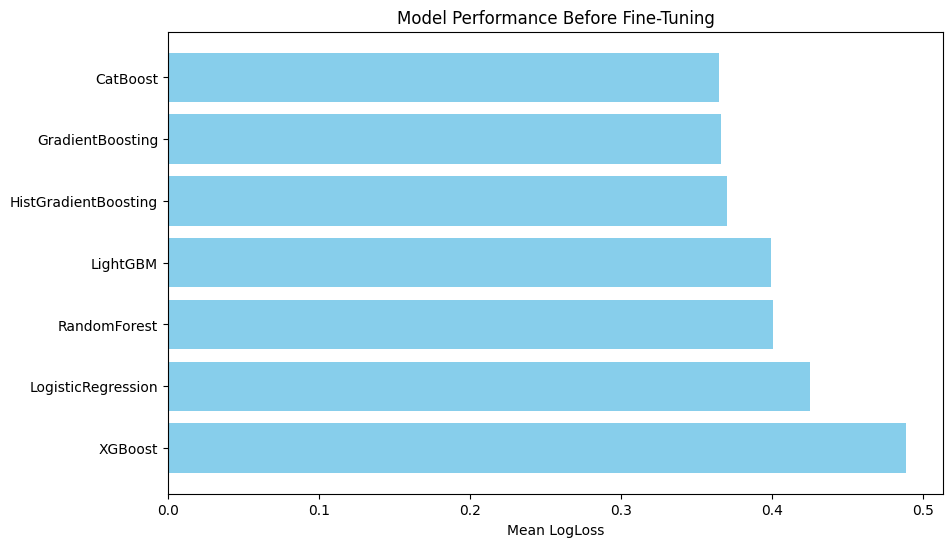

In [ ]:
# Bar plot of initial model performance
df_cmp = pd.DataFrame(candidates_sorted)

plt.figure(figsize=(10,6))
plt.barh(df_cmp['name'], df_cmp['mean_logloss'], color='skyblue')
plt.xlabel("Mean LogLoss")
plt.title("Model Performance Before Fine-Tuning")
plt.gca().invert_yaxis()
plt.show()


## 6. Optuna Hyperparameter Tuning for Top-3 Models

For each of the automatically selected top-3 models, we run an Optuna study to
minimise cross-validated multi-class log loss.


In [ ]:
def objective_logreg(trial):
    C = trial.suggest_float("C", 1e-3, 10, log=True)
    clf = LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        C=C
    )
    pipe = Pipeline([("preprocess", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring="neg_log_loss", n_jobs=1)
    return -scores.mean()


def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "max_depth": trial.suggest_int("max_depth", 5, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_float("max_features", 0.4, 1.0),
    }
    clf = RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        **params
    )
    pipe = Pipeline([("preprocess", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring="neg_log_loss", n_jobs=1)
    return -scores.mean()


def objective_hgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-4, 10.0, log=True),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 20, 80),
    }
    clf = HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        **params
    )
    pipe = Pipeline([("preprocess", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring="neg_log_loss", n_jobs=1)
    return -scores.mean()


def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
    }
    clf = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        **params
    )
    pipe = Pipeline([("preprocess", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring="neg_log_loss", n_jobs=1)
    return -scores.mean()


def objective_cat(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "iterations": trial.suggest_int("iterations", 200, 800),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
    }
    clf = CatBoostClassifier(
        loss_function="MultiClass",
        random_seed=RANDOM_STATE,
        verbose=False,
        **params
    )
    pipe = Pipeline([("preprocess", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring="neg_log_loss", n_jobs=1)
    return -scores.mean()


def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 80),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    }
    clf = LGBMClassifier(
        objective="multiclass",
        num_class=3,
        random_state=RANDOM_STATE,
        **params
    )
    pipe = Pipeline([("preprocess", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring="neg_log_loss", n_jobs=1)
    return -scores.mean()

def objective_gb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_float("max_features", 0.4, 1.0),
    }
    clf = GradientBoostingClassifier(random_state=RANDOM_STATE, **params)
    pipe = Pipeline([("preprocess", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring="neg_log_loss", n_jobs=1)
    return -scores.mean()

# Map model name -> objective function
objective_map = {
    "LogisticRegression": objective_logreg,
    "RandomForest": objective_rf,
    "HistGradientBoosting": objective_hgb,
    "XGBoost": objective_xgb,
    "CatBoost": objective_cat,
    "LightGBM": objective_lgbm,
    "GradientBoosting": objective_gb,
}

best_params = {}

for name in top3_names:
    if name not in objective_map:
        print(f"Skipping {name} (no Optuna objective defined).")
        continue
    print(f"\n==== Optuna tuning for {name} ====")
    study = optuna.create_study(direction="minimize", study_name=name)
    study.optimize(objective_map[name], n_trials=40, show_progress_bar=False)
    print("Best logloss:", study.best_value)
    print("Best params:", study.best_params)
    best_params[name] = study.best_params

best_params

[I 2025-11-27 14:11:37,244] A new study created in memory with name: CatBoost



==== Optuna tuning for CatBoost ====


[I 2025-11-27 14:11:52,571] Trial 0 finished with value: 0.36652489254784826 and parameters: {'depth': 5, 'learning_rate': 0.05384254514545489, 'iterations': 373, 'l2_leaf_reg': 1.1252248747024522}. Best is trial 0 with value: 0.36652489254784826.
[I 2025-11-27 14:12:22,329] Trial 1 finished with value: 0.3861316904423878 and parameters: {'depth': 5, 'learning_rate': 0.16597076089223234, 'iterations': 729, 'l2_leaf_reg': 0.07984737824534928}. Best is trial 0 with value: 0.36652489254784826.
[I 2025-11-27 14:12:22,329] Trial 1 finished with value: 0.3861316904423878 and parameters: {'depth': 5, 'learning_rate': 0.16597076089223234, 'iterations': 729, 'l2_leaf_reg': 0.07984737824534928}. Best is trial 0 with value: 0.36652489254784826.
[I 2025-11-27 14:12:35,087] Trial 2 finished with value: 0.37048057009662744 and parameters: {'depth': 5, 'learning_rate': 0.1951603159053064, 'iterations': 271, 'l2_leaf_reg': 0.06142588676425202}. Best is trial 0 with value: 0.36652489254784826.
[I 2025-

Best logloss: 0.36027663079389044
Best params: {'depth': 5, 'learning_rate': 0.08787588664594989, 'iterations': 666, 'l2_leaf_reg': 2.8347492076414804}

==== Optuna tuning for GradientBoosting ====


[I 2025-11-27 14:43:34,382] Trial 0 finished with value: 0.35531085608602087 and parameters: {'n_estimators': 389, 'learning_rate': 0.06246396312374219, 'subsample': 0.6248117846278398, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.6278773197621668}. Best is trial 0 with value: 0.35531085608602087.
[I 2025-11-27 14:44:12,616] Trial 1 finished with value: 0.3645727344776214 and parameters: {'n_estimators': 217, 'learning_rate': 0.0763726919988062, 'subsample': 0.7036925885787548, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 0.4559875751599351}. Best is trial 0 with value: 0.35531085608602087.
[I 2025-11-27 14:44:12,616] Trial 1 finished with value: 0.3645727344776214 and parameters: {'n_estimators': 217, 'learning_rate': 0.0763726919988062, 'subsample': 0.7036925885787548, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 0.4559875751599351}. Best is trial 0 with value: 0.35531085608602087.

Best logloss: 0.3542186203797555
Best params: {'n_estimators': 453, 'learning_rate': 0.1255173175186705, 'subsample': 0.6465733071603929, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.757695896428914}

==== Optuna tuning for HistGradientBoosting ====


[I 2025-11-27 15:53:34,779] Trial 0 finished with value: 0.3676269350522583 and parameters: {'learning_rate': 0.0424196689212993, 'max_depth': 10, 'l2_regularization': 0.00012025752920375971, 'max_leaf_nodes': 36}. Best is trial 0 with value: 0.3676269350522583.
[I 2025-11-27 15:53:39,613] Trial 1 finished with value: 0.3659033183763265 and parameters: {'learning_rate': 0.15506239613250264, 'max_depth': 6, 'l2_regularization': 8.928388132398664, 'max_leaf_nodes': 45}. Best is trial 1 with value: 0.3659033183763265.
[I 2025-11-27 15:53:39,613] Trial 1 finished with value: 0.3659033183763265 and parameters: {'learning_rate': 0.15506239613250264, 'max_depth': 6, 'l2_regularization': 8.928388132398664, 'max_leaf_nodes': 45}. Best is trial 1 with value: 0.3659033183763265.
[I 2025-11-27 15:53:48,649] Trial 2 finished with value: 0.3682138601945379 and parameters: {'learning_rate': 0.026798824899767495, 'max_depth': 7, 'l2_regularization': 3.4846776104440007, 'max_leaf_nodes': 34}. Best is t

Best logloss: 0.3616439268888315
Best params: {'learning_rate': 0.09405259722239, 'max_depth': 4, 'l2_regularization': 0.006367667429259721, 'max_leaf_nodes': 25}


{'CatBoost': {'depth': 5,
  'learning_rate': 0.08787588664594989,
  'iterations': 666,
  'l2_leaf_reg': 2.8347492076414804},
 'GradientBoosting': {'n_estimators': 453,
  'learning_rate': 0.1255173175186705,
  'subsample': 0.6465733071603929,
  'max_depth': 2,
  'min_samples_split': 5,
  'min_samples_leaf': 3,
  'max_features': 0.757695896428914},
 'HistGradientBoosting': {'learning_rate': 0.09405259722239,
  'max_depth': 4,
  'l2_regularization': 0.006367667429259721,
  'max_leaf_nodes': 25}}

### Optuna Convergence Plot

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)


## 6b. Final Single Tuned Model (Pre-Stacking)

Before building the stacking ensemble, we optionally train and submit the best single tuned model (among the top-3).

In [ ]:
# Helper + selection and submission for best single tuned model
from sklearn.base import clone

def make_tuned_estimator_single(name):
    params = best_params.get(name, {})
    if name == "LogisticRegression":
        return LogisticRegression(max_iter=1000, multi_class="multinomial", **params)
    elif name == "RandomForest":
        return RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, **params)
    elif name == "HistGradientBoosting":
        return HistGradientBoostingClassifier(random_state=RANDOM_STATE, **params)
    elif name == "GradientBoosting":
        return GradientBoostingClassifier(random_state=RANDOM_STATE, **params)
    elif name == "XGBoost":
        return XGBClassifier(objective="multi:softprob", num_class=3, eval_metric="mlogloss", tree_method="hist", random_state=RANDOM_STATE, n_jobs=-1, **params)
    elif name == "CatBoost":
        return CatBoostClassifier(loss_function="MultiClass", random_seed=RANDOM_STATE, verbose=False, **params)
    elif name == "LightGBM":
        return LGBMClassifier(objective="multiclass", num_class=3, random_state=RANDOM_STATE, **params)
    else:
        raise ValueError(f"Unknown model name: {name}")

single_results = []
print("\n=== Evaluating tuned single models (pre-stacking) ===")
for name in top3_names:
    if name not in best_params:
        print(f"Skipping {name} (no tuned params present).")
        continue
    est = make_tuned_estimator_single(name)
    pipe = Pipeline([("preprocess", preprocessor), ("clf", est)])
    scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring="neg_log_loss", n_jobs=1)
    mean_ll = -scores.mean()
    print(f"{name:25s} tuned CV logloss = {mean_ll:.5f}   folds = {(-scores).round(5)}")
    single_results.append((name, mean_ll, est))

if not single_results:
    raise RuntimeError("No tuned models available for single-model submission.")

single_best_name, single_best_ll, single_best_est = sorted(single_results, key=lambda t: t[1])[0]
print(f"\nSelected best single tuned model: {single_best_name} (CV logloss {single_best_ll:.5f})")

# Fit best single tuned model on full training data
single_model = Pipeline([("preprocess", preprocessor), ("clf", clone(single_best_est))])
single_model.fit(X, y_enc)

X_test = test_fe[feature_cols]
proba_test_single = single_model.predict_proba(X_test)
encoded_classes_single = single_model.named_steps["clf"].classes_
orig_classes_single = le.inverse_transform(encoded_classes_single)
class_to_index_single = {cls: i for i, cls in enumerate(orig_classes_single)}

sub_single = pd.DataFrame({
    "id": test_fe["id"],
    "Status_C":  proba_test_single[:, class_to_index_single["C"]],
    "Status_CL": proba_test_single[:, class_to_index_single["CL"]],
    "Status_D":  proba_test_single[:, class_to_index_single["D"]],
})

# Clip for numerical stability
_eps = 1e-15
for col in ["Status_C", "Status_CL", "Status_D"]:
    sub_single[col] = np.clip(sub_single[col], _eps, 1 - _eps)

OUT_PATH_SINGLE = DATA_DIR / "submission_single_optuna_labeled.csv"
sub_single.to_csv(OUT_PATH_SINGLE, index=False)
print("Single-model submission written to:", OUT_PATH_SINGLE)
sub_single.head()


=== Evaluating tuned single models (pre-stacking) ===
CatBoost                  tuned CV logloss = 0.36028   folds = [0.35504 0.36716 0.36523 0.35867 0.35529]
CatBoost                  tuned CV logloss = 0.36028   folds = [0.35504 0.36716 0.36523 0.35867 0.35529]
GradientBoosting          tuned CV logloss = 0.35422   folds = [0.35115 0.36499 0.35958 0.34595 0.34942]
GradientBoosting          tuned CV logloss = 0.35422   folds = [0.35115 0.36499 0.35958 0.34595 0.34942]
HistGradientBoosting      tuned CV logloss = 0.36164   folds = [0.35772 0.37112 0.36857 0.35757 0.35324]

Selected best single tuned model: GradientBoosting (CV logloss 0.35422)
HistGradientBoosting      tuned CV logloss = 0.36164   folds = [0.35772 0.37112 0.36857 0.35757 0.35324]

Selected best single tuned model: GradientBoosting (CV logloss 0.35422)
Single-model submission written to: C:\Users\USER\Desktop\BAIC\data\submission_single_optuna_labeled.csv
Single-model submission written to: C:\Users\USER\Desktop\BAIC\d

,id,Status_C,Status_CL,Status_D
0,15000,0.959994,0.006442,0.033564
1,15001,0.981718,0.001531,0.016750
2,15002,0.679766,0.028296,0.291938
3,15003,0.039975,0.000397,0.959628
4,15004,0.944892,0.002412,0.052696


## 7. Build Stacking Ensemble with Tuned Models

We now construct a **StackingClassifier** whose base learners are the tuned
versions of the top-3 models. The final estimator is a multinomial logistic
regression trained on the out-of-fold predicted probabilities of the base models.


In [ ]:
def make_tuned_estimator(name):
    params = best_params.get(name, {})
    if name == "LogisticRegression":
        return LogisticRegression(
            max_iter=1000,
            multi_class="multinomial",
            **params
        )
    elif name == "RandomForest":
        return RandomForestClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            **params
        )
    elif name == "HistGradientBoosting":
        return HistGradientBoostingClassifier(
            random_state=RANDOM_STATE,
            **params
        )
    elif name == "GradientBoosting":
        return GradientBoostingClassifier(
            random_state=RANDOM_STATE,
            **params
        )
    elif name == "XGBoost":
        return XGBClassifier(
            objective="multi:softprob",
            num_class=3,
            eval_metric="mlogloss",
            tree_method="hist",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            **params
        )
    elif name == "CatBoost":
        return CatBoostClassifier(
            loss_function="MultiClass",
            random_seed=RANDOM_STATE,
            verbose=False,
            **params
        )
    elif name == "LightGBM":
        return LGBMClassifier(
            objective="multiclass",
            num_class=3,
            random_state=RANDOM_STATE,
            **params
        )
    else:
        raise ValueError(f"Unknown model name: {name}")

base_estimators = []
for name in top3_names:
    if name not in best_params:
        print(f"Skipping {name} in stacking (no tuned params).")
        continue
    est = make_tuned_estimator(name)
    base_estimators.append((name, est))

print("Base estimators in stack:", [n for n, _ in base_estimators])

final_estimator = LogisticRegression(max_iter=1000, multi_class="multinomial")

stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    stack_method="predict_proba",
    n_jobs=-1
)

stack_model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", stack_clf)
])

stack_scores = cross_val_score(
    stack_model, X, y_enc,
    cv=cv,
    scoring="neg_log_loss",
    n_jobs=1
)
print("Stacking CV logloss per fold:", -stack_scores)
print("Stacking mean CV logloss:", -stack_scores.mean())

Base estimators in stack: ['CatBoost', 'GradientBoosting', 'HistGradientBoosting']


d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it w

Stacking CV logloss per fold: [0.3702633  0.38013398 0.3763956  0.3700882  0.36847886]
Stacking mean CV logloss: 0.3730719885739059


## 8. Train Final Model on Full Data & Generate Kaggle Submission

We fit the tuned stacking model on the **full training set** and generate
probability predictions for the test set. The probabilities are arranged into
columns `Status_C`, `Status_CL`, `Status_D` as required by the competition.


In [ ]:
# Fit on full encoded data
stack_model.fit(X, y_enc)

X_test = test_fe[feature_cols]
proba_test = stack_model.predict_proba(X_test)

# Classes in encoded form (0,1,2)
encoded_classes = stack_model.named_steps["clf"].classes_
print("Encoded classes:", encoded_classes)

# Map back to original labels using LabelEncoder
orig_classes = le.inverse_transform(encoded_classes)
print("Original class order:", orig_classes)

class_to_index = {cls: i for i, cls in enumerate(orig_classes)}
print("class_to_index:", class_to_index)

sub = pd.DataFrame({
    "id": test_fe["id"],
    "Status_C":  proba_test[:, class_to_index["C"]],
    "Status_CL": proba_test[:, class_to_index["CL"]],
    "Status_D":  proba_test[:, class_to_index["D"]],
})

# Clip probabilities to avoid extreme values
eps = 1e-15
for col in ["Status_C", "Status_CL", "Status_D"]:
    sub[col] = np.clip(sub[col], eps, 1 - eps)

OUT_PATH = DATA_DIR / "submission_stacking_optuna_labeled.csv"
sub.to_csv(OUT_PATH, index=False)
OUT_PATH, sub.head()


d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Encoded classes: [0 1 2]
Original class order: ['C' 'CL' 'D']
class_to_index: {'C': 0, 'CL': 1, 'D': 2}


(WindowsPath('C:/Users/USER/Desktop/BAIC/data/submission_stacking_optuna_labeled.csv'),
       id  Status_C  Status_CL  Status_D
 0  15000  0.937338   0.010589  0.052073
 1  15001  0.946903   0.009262  0.043835
 2  15002  0.777431   0.025402  0.197167
 3  15003  0.051477   0.012297  0.936226
 4  15004  0.937952   0.010197  0.051851)

## Top-3 Performance: Before vs After Tuning
This chart compares cross-validated multi-class log loss for the automatically selected top-3 models before hyperparameter tuning and after tuning (Optuna). Lower is better.


Improvements (Before - After) and % improvement:
GradientBoosting         : 0.01174  (3.21%)
CatBoost                 : 0.00466  (1.28%)
HistGradientBoosting     : 0.00833  (2.25%)


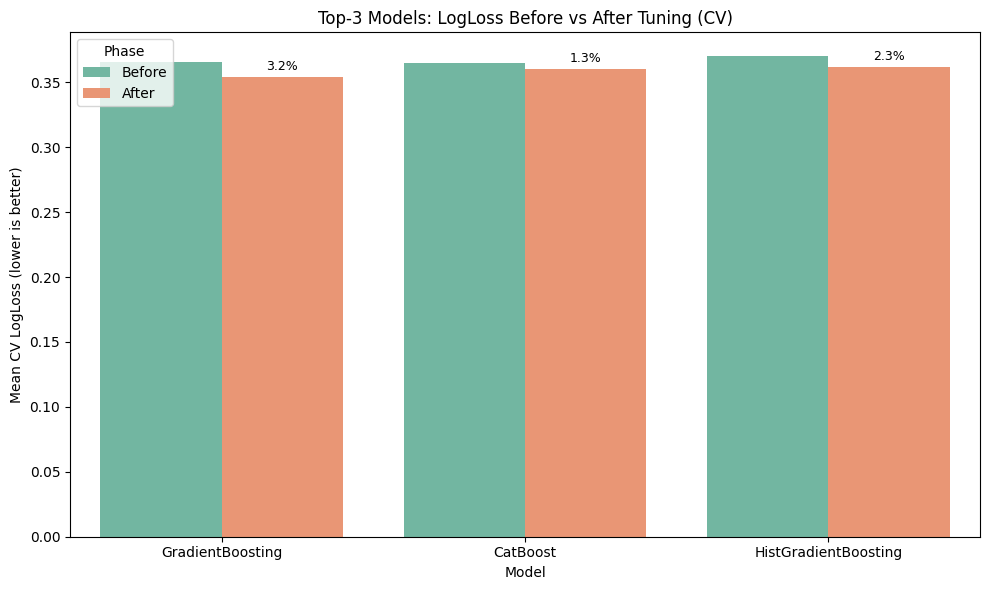

In [ ]:
# Compare top-3 before vs after tuning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collect before-tuning metrics for top-3
before_map = {}
try:
    before_map = {c['name']: c['mean_logloss'] for c in candidates_sorted if c['name'] in top3_names}
except Exception as e:
    print("Before metrics missing; run the baseline comparison cell.", e)

# Collect after-tuning metrics for top-3 (from single_results if available)
after_map = {}
try:
    after_map = {name: ll for (name, ll, _est) in single_results}
except Exception:
    # Fallback: compute quickly from tuned estimators if available
    try:
        tmp_results = []
        for name in top3_names:
            if name not in best_params:
                print(f"Skipping {name} (no tuned params).")
                continue
            est = make_tuned_estimator_single(name) if 'make_tuned_estimator_single' in globals() else make_tuned_estimator(name)
            pipe = Pipeline([('preprocess', preprocessor), ('clf', est)])
            scores = cross_val_score(pipe, X, y_enc, cv=cv, scoring='neg_log_loss', n_jobs=1)
            ll = -scores.mean()
            tmp_results.append((name, ll))
        after_map = dict(tmp_results)
    except Exception as e2:
        print("After-tuning metrics missing; run the tuning + single-model eval cells.", e2)

# Build plotting DataFrame for the intersection of names we have
names = [n for n in top3_names if n in before_map and n in after_map]
if not names:
    print("No overlapping metrics to plot.")
else:
    rows = []
    for n in names:
        rows.append({'name': n, 'phase': 'Before', 'logloss': before_map[n]})
        rows.append({'name': n, 'phase': 'After',  'logloss': after_map[n]})
    df_plot = pd.DataFrame(rows)

    # Order by After-tuning performance (best first)
    order = (df_plot[df_plot['phase']=='After']
             .sort_values('logloss', ascending=True)['name'].tolist())

    plt.figure(figsize=(10,6))
    ax = sns.barplot(data=df_plot, x='name', y='logloss', hue='phase', hue_order=['Before','After'], order=order, palette='Set2')
    plt.title('Top-3 Models: LogLoss Before vs After Tuning (CV)')
    plt.xlabel('Model')
    plt.ylabel('Mean CV LogLoss (lower is better)')
    plt.legend(title='Phase')

    # Compute and print improvements with percentages
    print('\nImprovements (Before - After) and % improvement:')
    pct_labels = []
    for n in order:
        before = before_map[n]
        after = after_map[n]
        delta = before - after
        pct = (delta / before * 100.0) if before > 0 else np.nan
        print(f"{n:25s}: {delta:.5f}  ({pct:.2f}%)")
        pct_labels.append(pct)

    # Try to annotate % on the 'After' bars if supported by Matplotlib
    try:
        # ax.containers[0] -> 'Before' bars, ax.containers[1] -> 'After' bars (due to hue_order)
        after_container = ax.containers[1]
        label_texts = [f"{p:.1f}%" if np.isfinite(p) else "" for p in pct_labels]
        ax.bar_label(after_container, labels=label_texts, label_type='edge', padding=3, fontsize=9, color='black')
    except Exception:
        pass

    plt.tight_layout()
    plt.show()
